In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score
%matplotlib inline

/home/dmitry/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [120]:
trans = pd.read_csv('data/transactions.csv')
print 'size of sata:', len(trans)
print 'unique MCC:', len(trans.mcc_code.unique())
# trans = trans.sample(100000).to_csv('transactions1e5.csv', index=False)

size of sata: 6849346
unique MCC: 184


In [33]:
trans = pd.read_csv('data/transactions.csv')
customers_gender = pd.read_csv('data/customers_gender_train.csv')
trans = pd.merge(trans, customers_gender, on='customer_id', how='left')
# day, day of year
trans['day'] = trans['tr_datetime'].str.split().str[0].astype(int)
trans['dayy'] = np.where(trans['day']>=153, trans['day'] - 152, trans['day'] - 152 + 365)
# amount
trans['amount'] = (trans['amount']/2.245915772).round(2)

X = pd.concat([trans['customer_id'],
               pd.get_dummies(trans['mcc_code']),
               trans['gender']],
              axis=1)
# del trans
X = X.groupby('customer_id').sum()
X['gender'][X['gender']>0] = 1
# print X

X_res = X[pd.isnull(X['gender'])].drop(['gender'], axis=1)
X.dropna(subset=['gender'], inplace=True) # train
Y = X['gender']
X.drop(['gender'], axis=1, inplace=True)
print X.head()
print Y.head()
print Y.value_counts()
# trans['daym'] = trans['day'] % 30.3
# trans['time'] = pd.to_timedelta(trans['tr_datetime'].str.split().str[1])

             742   1711  1731  1799  2741  3000  3351  3501  4111  4112  ...   \
customer_id                                                              ...    
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
27914         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
28753         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
31385         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

             8299  8398  8641  8699  8999  9211  9222  9311  9399  9402  
customer_id                                                              
6815          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
22899         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
27914         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
28753         0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   

In [342]:
X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=0, stratify=Y)

def xgbtree(clf_skl, n_est):
    # find best n_estimators value
    xgb_params = clf_skl.get_xgb_params()
    xgb_params['eval_metric'] = 'auc'
    xgb_params['nthread'] = 24
    xgb_train = xgb.DMatrix(data=X_train, label=Y_train)
    xgb_test = xgb.DMatrix(data=X_test, label=y_test)
    evals = [(xgb_train, 'train'), (xgb_test, 'test')]
    clf_xgb = xgb.train(xgb_params, xgb_train, n_est, evals, verbose_eval=50, early_stopping_rounds=50)
    print clf_xgb.best_iteration, clf_xgb.best_score
#     cvres = xgb.cv(xgb_params, xgb_train, 200, nfold=5, verbose_eval=10) # cross validation
    
def skltree(clf_skl, n_est):
    clf_skl.set_params(n_estimators=n_est)
    clf_skl.fit(X_train, Y_train, eval_metric='auc',
              eval_set=[(X_train,Y_train), (X_test,y_test)], early_stopping_rounds=50, verbose=False)
    y_proba = clf_skl.predict_proba(X_test)[:,1]
#     print roc_auc_score(y_test, y_proba)
    print clf_skl.best_iteration, clf_skl.best_score
    
def grid_search(param_grid):
    cv = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)
    gsearch = GridSearchCV(model, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=1, verbose=1, refit=True)
    gsearch.fit(X, Y)
    res = map(lambda a, b, c: str(a) + ' ' + str(b) + ' ' + str(c),
                gsearch.cv_results_['mean_train_score'],
                gsearch.cv_results_['mean_test_score'],
                gsearch.cv_results_['params'])
    print gsearch.best_score_, gsearch.best_params_
    print '\n'.join(res)

In [359]:
model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    learning_rate = 0.03,
    n_estimators = 300,
    max_depth = 5,
    min_child_weight = 9,
    gamma = 0.8,
    subsample = 0.4,
    colsample_bytree = 0.6,
    silent = False,
    )
model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.8, learning_rate=0.03, max_delta_step=0, max_depth=5,
       min_child_weight=9, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.4)

In [352]:
xgbtree(model, n_est=1000)

[0]	train-auc:0.731134	test-auc:0.717265
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.854518	test-auc:0.830672
[100]	train-auc:0.872162	test-auc:0.844871
[150]	train-auc:0.883698	test-auc:0.85355
[200]	train-auc:0.89189	test-auc:0.859464
[250]	train-auc:0.897775	test-auc:0.863334
[300]	train-auc:0.902319	test-auc:0.865852
[350]	train-auc:0.905622	test-auc:0.867461
[400]	train-auc:0.908364	test-auc:0.868025
[450]	train-auc:0.910926	test-auc:0.868637
[500]	train-auc:0.913863	test-auc:0.870234
[550]	train-auc:0.916212	test-auc:0.870417
Stopping. Best iteration:
[519]	train-auc:0.914751	test-auc:0.870713

519 0.870713


In [349]:
grid_search({
        'max_depth':range(4,10,2),
        'min_child_weight':range(3,11,2),
        })

Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   42.6s finished


0.868802428477 {'max_depth': 6, 'min_child_weight': 9}
0.921666984908 0.86680851969 {'max_depth': 4, 'min_child_weight': 3}
0.918871887896 0.867086928667 {'max_depth': 4, 'min_child_weight': 5}
0.916432688149 0.86689298084 {'max_depth': 4, 'min_child_weight': 7}
0.914052369466 0.867621223648 {'max_depth': 4, 'min_child_weight': 9}
0.953472073385 0.867858966145 {'max_depth': 6, 'min_child_weight': 3}
0.947208390649 0.867541141965 {'max_depth': 6, 'min_child_weight': 5}
0.941841445879 0.867690043845 {'max_depth': 6, 'min_child_weight': 7}
0.938169289881 0.868802428477 {'max_depth': 6, 'min_child_weight': 9}
0.975500917703 0.868762387635 {'max_depth': 8, 'min_child_weight': 3}
0.966736134113 0.868525896414 {'max_depth': 8, 'min_child_weight': 5}
0.960868661323 0.867359706901 {'max_depth': 8, 'min_child_weight': 7}
0.95445709398 0.867439788584 {'max_depth': 8, 'min_child_weight': 9}


In [292]:
grid_search({
        'gamma': np.arange(0,1,0.2),
        })

Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.2s finished


0.86481147395 {'gamma': 0.80000000000000004}
0.953969727663 0.864517600387 {'gamma': 0.0}
0.95251387088 0.863107007283 {'gamma': 0.20000000000000001}
0.954171689877 0.863939003814 {'gamma': 0.40000000000000002}
0.952817847987 0.864140316004 {'gamma': 0.60000000000000009}
0.953789233008 0.86481147395 {'gamma': 0.80000000000000004}


In [360]:
grid_search({
        'subsample': np.arange(0.2,1,0.2),
        'colsample_bytree': np.arange(0.2,1,0.2),
        })

Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   23.0s finished


0.865876944483 {'subsample': 0.40000000000000002, 'colsample_bytree': 0.60000000000000009}
0.886628795997 0.860083535206 {'subsample': 0.20000000000000001, 'colsample_bytree': 0.20000000000000001}
0.897637450851 0.864822118561 {'subsample': 0.40000000000000002, 'colsample_bytree': 0.20000000000000001}
0.901929241405 0.865723663136 {'subsample': 0.60000000000000009, 'colsample_bytree': 0.20000000000000001}
0.905695992892 0.864807728883 {'subsample': 0.80000000000000004, 'colsample_bytree': 0.20000000000000001}
0.889147744321 0.861516246572 {'subsample': 0.20000000000000001, 'colsample_bytree': 0.40000000000000002}
0.900195932491 0.863746020941 {'subsample': 0.40000000000000002, 'colsample_bytree': 0.40000000000000002}
0.906150869577 0.863538309075 {'subsample': 0.60000000000000009, 'colsample_bytree': 0.40000000000000002}
0.908981700498 0.862368991371 {'subsample': 0.80000000000000004, 'colsample_bytree': 0.40000000000000002}
0.891544410196 0.864360397606 {'subsample': 0.200000000000000

In [356]:
grid_search({
        'reg_lambda': [0.8, 1, 1.2],
        })

Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.8s finished


0.871311237462 {'reg_lambda': 1}
0.922981560212 0.87081448077 {'reg_lambda': 0.8}
0.922700423585 0.871311237462 {'reg_lambda': 1}
0.92289481683 0.869491881719 {'reg_lambda': 1.2}


In [355]:
# write result
# model.set_params(**gsearch.best_params_)
model.fit(X, Y, eval_metric='auc', verbose=True)
res = pd.DataFrame({'gender': model.predict_proba(X_res)[:,1]}, index=X_res.index)
res.to_csv('a.csv')
res.head()

,gender
customer_id,
49101,0.378000
114348,0.767054
127946,0.811515
137367,0.466644
174467,0.698632


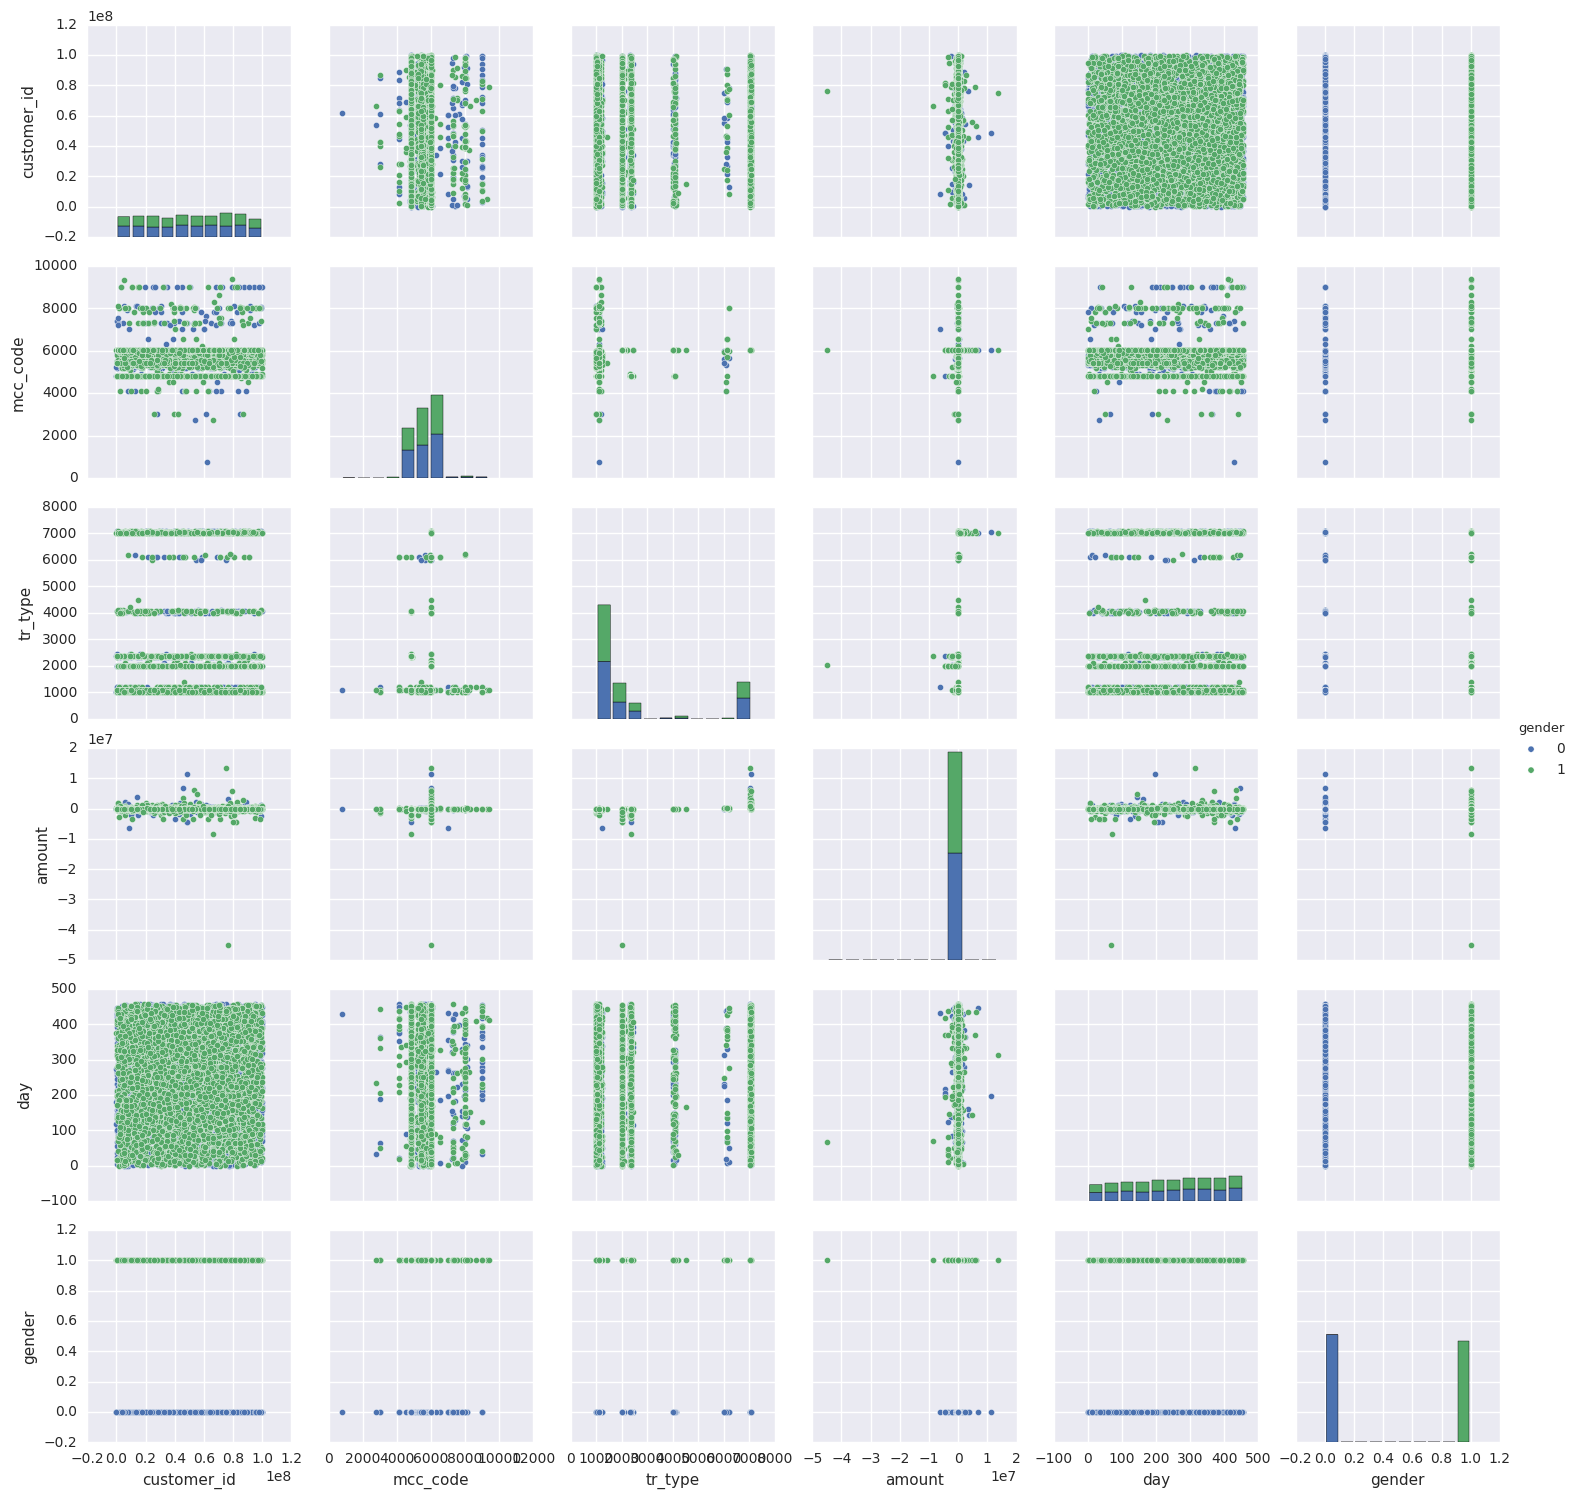

In [69]:
sns.pairplot(XY, hue="gender")

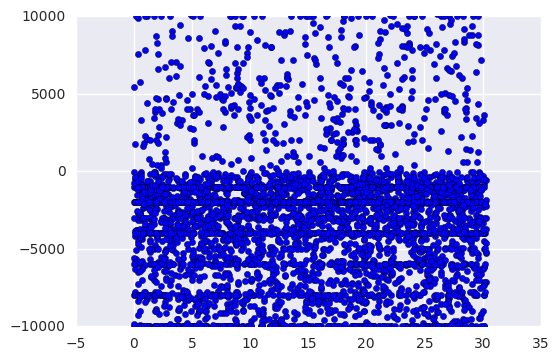

In [4]:
plt.scatter(XY.daym, XY.amount)
# plt.xlim(0,90)
plt.ylim(-1e4,1e4)
plt.show()

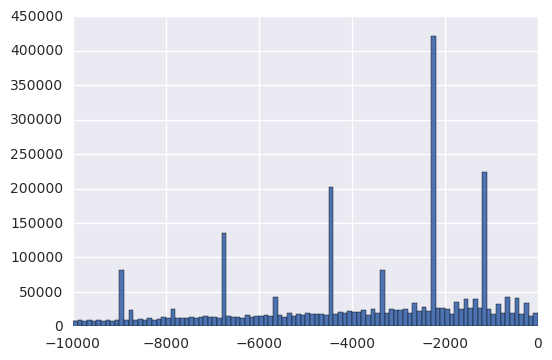

In [367]:
plt.hist(trans.amount, bins=100, range=(-1e4,0))
# plt.hist(XY.amount, bins=100, range=(0,1e5))
plt.show()

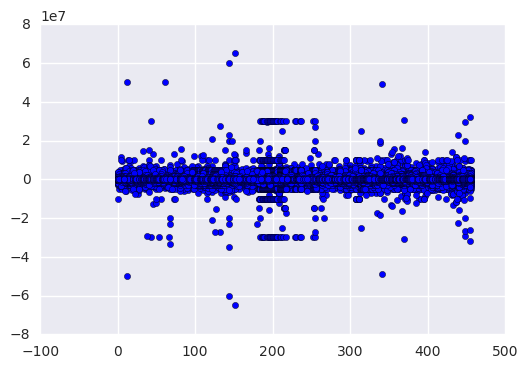

In [370]:
plt.scatter(trans.day, trans.amount)
plt.show()

In [375]:
trans[abs(trans.amount)==3e7]

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,day
123977,40917212,43 17:10:40,6010,7070,30000000.0,NaN,0.0,43
123978,40917212,43 17:10:25,4829,2370,-30000000.0,NaN,0.0,43
162550,82581973,192 18:18:17,6010,7020,30000000.0,NaN,1.0,192
2768759,97994480,53 10:31:41,6010,2020,-30000000.0,NaN,NaN,53
2768795,97994480,66 07:34:00,6010,2020,-30000000.0,NaN,NaN,66
6519602,48281795,183 10:53:60,4829,2370,-30000000.0,NaN,0.0,183
6519603,48281795,183 10:53:15,6010,7070,30000000.0,NaN,0.0,183
6519658,48281795,186 09:41:27,4829,2370,-30000000.0,NaN,0.0,186
6519659,48281795,186 09:41:24,6010,7070,30000000.0,NaN,0.0,186
6519689,48281795,187 09:43:59,4829,2370,-30000000.0,NaN,0.0,187


In [10]:
a = trans[trans.amount<0].groupby('day').sum()

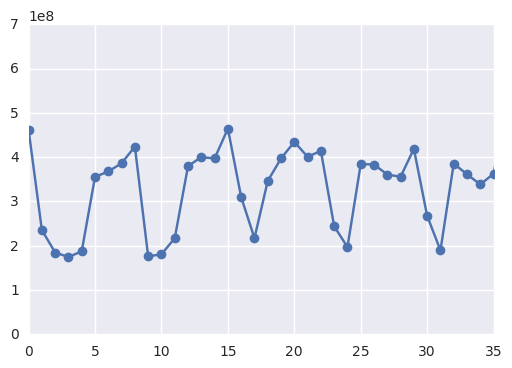

[0, 456]


In [30]:


plt.plot(a.index-152-31-28-31-30, -a.amount, 'o-')
plt.xlim((0,35))
plt.show()
print [trans.day.min(), trans.day.max()]